Epoch 0, Loss: 0.01617528684437275
Epoch 1000, Loss: 5.248564320936566e-07
Epoch 2000, Loss: 1.14284517849228e-07
Epoch 3000, Loss: 3.6936594227654496e-08
Epoch 4000, Loss: 1.5945239795200905e-08
Epoch 5000, Loss: 8.310833798930162e-09
Epoch 6000, Loss: 5.43552314269391e-09
Epoch 7000, Loss: 3.75302411370626e-09
Epoch 8000, Loss: 3.225931965999962e-09
Epoch 9000, Loss: 2.2259145637804068e-09


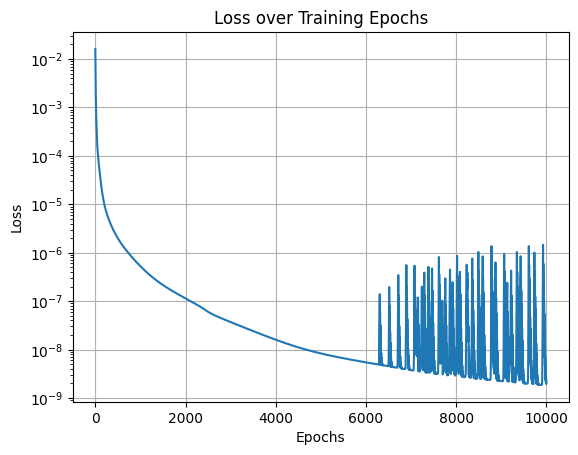

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Define the Neural Network model for the PINN
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.sin(self.hidden1(x))
        x = torch.sin(self.hidden2(x))
        return self.output(x)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define physical parameters
speed_factor = 0.1  # Warp bubble velocity factor
sigma = 1.0  # Determines bubble wall thickness
learning_rate = 1e-3  # Learning rate for optimizers
epochs = 10000  # Number of training epochs

# Initialize network and optimizer
net = Net(input_dim=2, hidden_dim=20, output_dim=2).to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Define the warp bubble loss function
def warp_bubble_loss(x, t):
    x.requires_grad = True
    t.requires_grad = True

    # Network prediction for the warp field and energy density
    output = net(torch.cat((x, t), dim=1))
    warp_field = output[:, 0]
    energy_density = output[:, 1]

    # Compute spatial and temporal derivatives
    warp_x = torch.autograd.grad(warp_field, x, grad_outputs=torch.ones_like(warp_field), create_graph=True)[0]
    warp_xx = torch.autograd.grad(warp_x, x, grad_outputs=torch.ones_like(warp_x), create_graph=True)[0]
    warp_tt = torch.autograd.grad(warp_field, t, grad_outputs=torch.ones_like(warp_field), create_graph=True)[0]

    # Define the loss components based on the Alcubierre metric
    f_x = warp_x * warp_field + sigma**2 * (warp_tt - warp_xx)
    einstein_eq_residual = warp_field**2 - energy_density**2

    # Total loss
    loss_f = torch.mean((f_x)**2)
    loss_einstein = torch.mean((einstein_eq_residual)**2)

    return loss_f + loss_einstein

# Initialize training loop
losses = []
for epoch in range(epochs):
    x = torch.linspace(-10, 10, steps=100).reshape(-1, 1).to(device)
    t = torch.linspace(0, 10, steps=100).reshape(-1, 1).to(device)

    optimizer.zero_grad()
    loss = warp_bubble_loss(x, t)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Visualization of loss over epochs
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Training Epochs')
plt.grid()
plt.show()

# Animation of the warp bubble shape progression over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-10, 10)
ax.set_ylim(-2, 2)
line, = ax.plot([], [], lw=2)
ax.set_xlabel('x')
ax.set_ylabel('Warp Field Intensity')
ax.set_title('Warp Bubble Shape Animation')

# Initialization function for the animation
def init():
    line.set_data([], [])
    return line,

# Animation function to update the line for each frame
def animate(t_val):
    x_plot = torch.linspace(-10, 10, 100).reshape(-1, 1).to(device)
    t_plot = torch.full_like(x_plot, t_val)

    with torch.no_grad():
        output_plot = net(torch.cat((x_plot, t_plot), dim=1))
        warp_field_plot = output_plot[:, 0].cpu().numpy()

    line.set_data(x_plot.cpu().numpy(), warp_field_plot)
    ax.set_title(f'Warp Bubble Shape at t = {t_val:.2f}')
    return line,

# Define the time values to animate over (0 to 10 seconds)
time_values = np.linspace(0, 10, 100)

# Create the animation
ani = animation.FuncAnimation(
    fig, animate, frames=time_values, init_func=init, blit=True, repeat=False
)

# Display the animation in Google Colab
plt.close(fig)  # Prevents static display of the last frame
HTML(ani.to_jshtml())
